In [10]:
# Remember you need to use SWAN with NXCALS support....
import datetime
import pytimber
ldb = pytimber.LoggingDB(source="nxcals")

In [11]:
# Just some simple imports
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('default')
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['text.usetex'] = True # sometimes best to keep it False for faster plotting...
plt.rcParams["figure.autolayout"] = True
plt.rcParams['font.size'] = 12
#plt.rcParams['font.family'] = "Helvetica"

### ELENA Cycle

In [12]:
# Data interval to be looked at: here very short, as I only care about present magnetic cycle...
t1 = '2021-10-29 16:00:00.000'
t2 = '2021-10-29 16:25:00.000'
t1 = '2021-11-14 16:00:00.000'
t2 = '2021-11-14 16:01:00.000'

CycleDATA = ldb.get(['LNR.BMEAS-B-ST:Samples:samples', 'LNR.BMEAS-B-ST:Samples:samplingTrain', 'LNR.BMEAS-B-ST:Samples:firstSampleTime'], t1, t2)
CycleDATA_values = CycleDATA['LNR.BMEAS-B-ST:Samples:samples'][1]



In [ ]:
idxToLookAt = 0
CycleDATA_values = CycleDATA['LNR.BMEAS-B-ST:Samples:samples'][1][idxToLookAt].flatten()
CycleDATA_samplingTrain = CycleDATA['LNR.BMEAS-B-ST:Samples:samplingTrain'][1][idxToLookAt]
CycleDATA_firstSampleTime = CycleDATA['LNR.BMEAS-B-ST:Samples:firstSampleTime'][1][idxToLookAt]
CycleDATA_time = CycleDATA_firstSampleTime + CycleDATA_samplingTrain*np.arange(len(CycleDATA_values))

plt.figure()
plt.plot(CycleDATA_time, CycleDATA_values)
plt.xlabel("t [ms]")
plt.ylabel("B [G]")


### Intensity in ELENA

In [ ]:
# Data interval to be looked at
# plot for COOL conference time
t1 = '2021-10-29 08:00:00.000'
t2 = '2021-10-29 20:00:00.000'
# 
#t1 = '2021-11-04 16:00:00.000'
#t2 = '2021-11-04 20:00:00.000'

In [ ]:
TPUDATA = ldb.get(['LNA.TPU_INTSY-ACQ:Data:samples', 'LNA.TPU_INTSY-ACQ:Data:samplingInterval'], t1, t2)
TPUDATA_values = TPUDATA['LNA.TPU_INTSY-ACQ:Data:samples'][1]
TPUDATA_intervals = TPUDATA['LNA.TPU_INTSY-ACQ:Data:samplingInterval'][1]

In [ ]:
# Identify the index of injection and extraciton, assuming they don't move...
indexInjection = 480
indexMidplateuStart = 709
indexMidplateuEnd   = 1120
indexEjection = 1840
indexSecondInj = 1375


plotAsTime = False
plt.figure()
for shotToPlot in np.arange(5,15,1):
    if plotAsTime:
        _interval = TPUDATA_intervals[shotToPlot]*1000
    else:
        _interval = 1
    _time = _interval*np.arange(len(TPUDATA_values[shotToPlot,:]))
    plt.plot(_time, TPUDATA_values[shotToPlot,:])
plt.plot(_interval*indexInjection,      TPUDATA_values[shotToPlot,indexInjection],'x')
plt.plot(_interval*indexMidplateuStart, TPUDATA_values[shotToPlot,indexMidplateuStart],'x')
plt.plot(_interval*indexMidplateuEnd,   TPUDATA_values[shotToPlot,indexMidplateuEnd],'x')
plt.plot(_interval*indexEjection,       TPUDATA_values[shotToPlot,indexEjection], 'x')
plt.plot(_interval*indexSecondInj,      TPUDATA_values[shotToPlot,indexSecondInj], 'x')

if plotAsTime:
    plt.xlabel("time [ms]")
else:
    plt.xlabel("index [#]")
plt.ylabel("intensity [#]")
plt.ylim([0, 4e7])
#plt.xlim([1350, 1400])

In [ ]:
ELENA_injected_values = TPUDATA_values[:,indexInjection]
ELENA_35Start_values  = TPUDATA_values[:,indexMidplateuStart]
ELENA_35End_values    = TPUDATA_values[:,indexMidplateuEnd]
ELENA_ejected_values  = TPUDATA_values[:,indexEjection]
ELENA_secondInj_values= TPUDATA_values[:,indexSecondInj]


ELENA_efficiency_percent = 100*np.divide(ELENA_ejected_values, ELENA_injected_values)
aux = ELENA_injected_values > 5e6
ELENA_efficiency_percent[~aux] = np.nan

plt.figure()
plt.plot(ELENA_injected_values, label = 'LLRF-TPU Injection')
plt.plot(ELENA_35Start_values, label = 'LLRF-TPU Start 35 MeV/c')
plt.plot(ELENA_35End_values, label = 'LLRF-TPU End 35 MeV/c')
plt.plot(ELENA_ejected_values, label = 'LLRF-TPU Ejection')
plt.plot(ELENA_secondInj_values, label = 'Second Injection')
plt.ylim([0, 5e7])

plt.xlabel("shot number")
plt.ylabel("Intensity [#]")
plt.legend()

plt.figure()
plt.plot(ELENA_efficiency_percent, label = '13.7 [MeV/c] / 100 [MeV/c]')
plt.xlabel("shot number")
plt.ylabel("100 -> 13.7 efficency [%]")


In [ ]:
# filter good cycles
hminusCycles = np.where((ELENA_secondInj_values > 0.2e7) & (ELENA_injected_values > 0.4e7))
pbarCycles   = np.where(ELENA_injected_values > 2.5e7)

In [ ]:
# Make nice plot comparing H- and pbar cycles

pbar_cycle_idx   = pbarCycles[0][np.argmax(ELENA_injected_values[pbarCycles])]
Hminus_cycle_idx = hminusCycles[0][np.argmax(ELENA_ejected_values[hminusCycles])]

plt.figure()
# plot magnetic cycle in BG
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(CycleDATA_time, CycleDATA_values, 'r--')
ax2.set_ylabel('B [G]', color='r')
ax2.spines['right'].set_color('r')
ax2.tick_params(axis='y', colors='r')

# pbars intensity
_interval = TPUDATA_intervals[pbar_cycle_idx]*1000
_time = _interval*np.arange(len(TPUDATA_values[pbar_cycle_idx,:]))
ax1.plot(_time, TPUDATA_values[pbar_cycle_idx,:],  label='pbar')
# H- intensity
_interval = TPUDATA_intervals[Hminus_cycle_idx]*1000
_time = _interval*np.arange(len(TPUDATA_values[Hminus_cycle_idx,:]))
ax1.plot(_time, TPUDATA_values[Hminus_cycle_idx,:],  label='H-')

# adjust some axis labels
ax1.set_xlabel("time [ms]")
ax1.set_ylabel("intensity [#]")
ax1.set_ylim([0, 4e7])
ax1.set_xlim([1000, 13000])
ax2.set_xlim([1000, 13000])


ax1.legend()



### And now the SEMs at Injection

In [9]:
SEMList_intensity = ['LNE50.BSGW.5020:FitAcq:gaussAmplitude','LNE50.BSGW.5060:FitAcq:gaussAmplitude']
SEMList_position = ['LNE50.BSGW.5020:FitAcq:gaussMean','LNE50.BSGW.5060:FitAcq:gaussMean']
SEMList_sigmas = ['LNE50.BSGW.5020:FitAcq:gaussSigma','LNE50.BSGW.5060:FitAcq:gaussSigma']

SEM_intensity = ldb.get(SEMList_intensity, t1, t2)
SEM_position  = ldb.get(SEMList_position, t1, t2)
SEM_sigmas  = ldb.get(SEMList_sigmas, t1, t2)

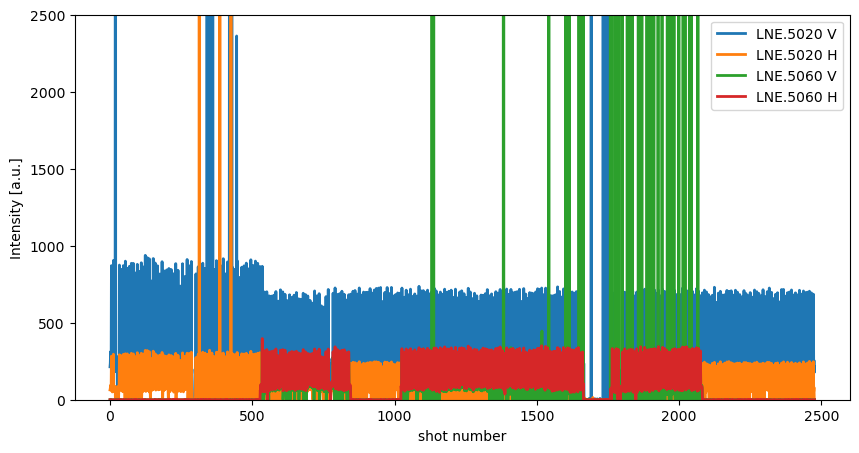

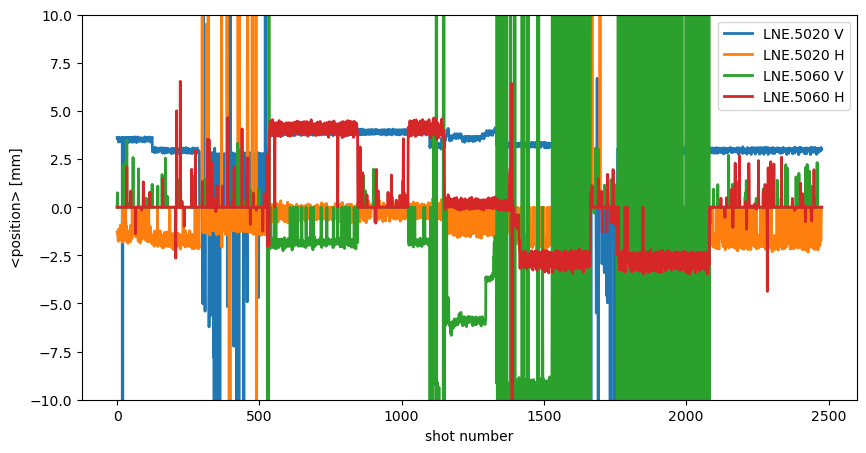

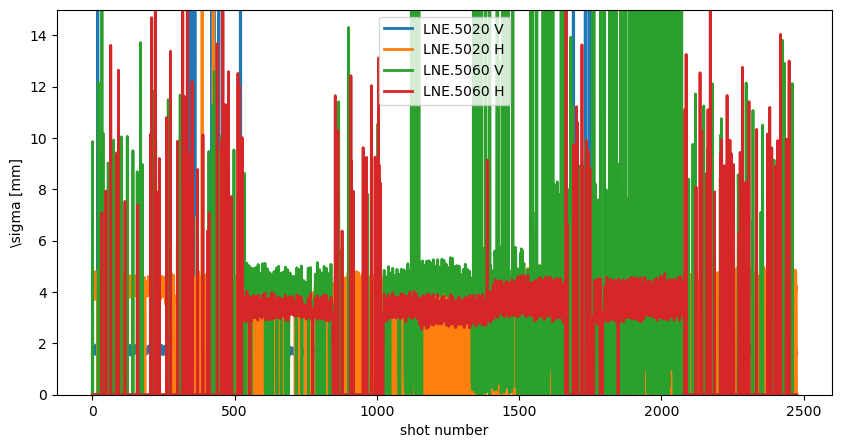

In [10]:
# Intensity
plt.figure()
plt.plot(SEM_intensity['LNE50.BSGW.5020:FitAcq:gaussAmplitude'][1][:,0], label='LNE.5020 V')
plt.plot(SEM_intensity['LNE50.BSGW.5020:FitAcq:gaussAmplitude'][1][:,1], label='LNE.5020 H')
plt.plot(SEM_intensity['LNE50.BSGW.5060:FitAcq:gaussAmplitude'][1][:,0], label='LNE.5060 V')
plt.plot(SEM_intensity['LNE50.BSGW.5060:FitAcq:gaussAmplitude'][1][:,1], label='LNE.5060 H')
plt.xlabel("shot number")
plt.ylabel("Intensity [a.u.]")
plt.ylim([0, 2.5e3])
plt.legend()

# Position
plt.figure()
plt.plot(SEM_position['LNE50.BSGW.5020:FitAcq:gaussMean'][1][:,0], label='LNE.5020 V')
plt.plot(SEM_position['LNE50.BSGW.5020:FitAcq:gaussMean'][1][:,1], label='LNE.5020 H')
plt.plot(SEM_position['LNE50.BSGW.5060:FitAcq:gaussMean'][1][:,0], label='LNE.5060 V')
plt.plot(SEM_position['LNE50.BSGW.5060:FitAcq:gaussMean'][1][:,1], label='LNE.5060 H')
plt.xlabel("shot number")
plt.ylabel("<position> [mm]")
plt.ylim([-10, 10])
plt.legend()

# Sigma
plt.figure()
plt.plot(SEM_sigmas['LNE50.BSGW.5020:FitAcq:gaussSigma'][1][:,0], label='LNE.5020 V')
plt.plot(SEM_sigmas['LNE50.BSGW.5020:FitAcq:gaussSigma'][1][:,1], label='LNE.5020 H')
plt.plot(SEM_sigmas['LNE50.BSGW.5060:FitAcq:gaussSigma'][1][:,0], label='LNE.5060 V')
plt.plot(SEM_sigmas['LNE50.BSGW.5060:FitAcq:gaussSigma'][1][:,1], label='LNE.5060 H')
plt.xlabel("shot number")
plt.ylabel("\sigma [mm]")
plt.ylim([0, 15])
plt.legend()


### Look for some correlation

Starting from emittance as a function of ejected beam intensity

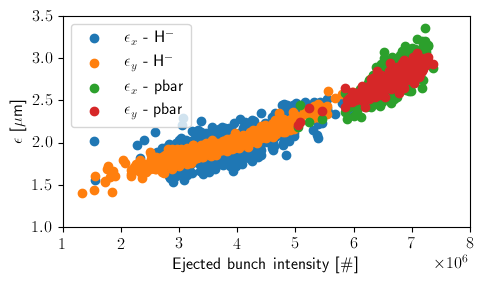

In [46]:
# emittance is computed as 
#   \epsilon = beam_sigma^2/twiss_beta

assumed_beta_x = 7.7
assumed_beta_y = 1.3

xvalue_bpar     = ELENA_ejected_values[pbarCycles]/4
corrValue1_pbar = np.power(SEM_sigmas['LNE50.BSGW.5020:FitAcq:gaussSigma'][1][pbarCycles,1],2)/assumed_beta_x
corrValue2_pbar = np.power(SEM_sigmas['LNE50.BSGW.5020:FitAcq:gaussSigma'][1][pbarCycles,0],2)/assumed_beta_y

xvalue_Hmin     = ELENA_ejected_values[hminusCycles]/4
corrValue1_Hmin = np.power(SEM_sigmas['LNE50.BSGW.5020:FitAcq:gaussSigma'][1][hminusCycles,1],2)/assumed_beta_x
corrValue2_Hmin = np.power(SEM_sigmas['LNE50.BSGW.5020:FitAcq:gaussSigma'][1][hminusCycles,0],2)/assumed_beta_y

plt.figure(figsize=[5,3])
plt.scatter(xvalue_Hmin, corrValue1_Hmin, label='$\epsilon_x$ - H$^-$')
plt.scatter(xvalue_Hmin, corrValue2_Hmin, label='$\epsilon_y$ - H$^-$')
plt.scatter(xvalue_bpar, corrValue1_pbar, label='$\epsilon_x$ - pbar')
plt.scatter(xvalue_bpar, corrValue2_pbar, label='$\epsilon_y$ - pbar')
plt.ylabel('$\epsilon$ [$\mu$m]')
plt.xlabel('Ejected bunch intensity [\#]')
#plt.axis('equal')
#plt.ylim([2e7,4.5e7])
plt.legend()
plt.ylim([1, 3.5])
plt.xlim([0.1e7,0.8e7])
plt.savefig('extracted_intensity.pdf')
